In [24]:
import torch
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {device}")

The device is cuda


In [26]:
# 定义 内容/风格/输出 文件夹
content_dir = './content'
style_dir = './style'
output_dir = './output'

# 图片的名称
content_name = 'Rohm'
style_name = 'Starry_Night'
output_name = f'{content_name}_' + f'{style_name}'

# 路径(默认格式jpg,可以自行修改png等)
content_path = f'./{content_dir}/' + f'{content_name}.jpg'
style_path = f'./{style_dir}/' + f'{style_name}.jpg'
output_path = f'./{output_dir}/' + f'sty{output_name}.jpg'

def load_image(image_path):
    try:
        image = Image.open(image_path)
        if image is None:
            raise ValueError(f'Can not load image, please check path:{image_path}')
    except Exception as e:
        raise ValueError(f"Can not read image:{e}")

    return image

content_image = load_image(content_path)
style_image = load_image(style_path)


In [27]:
# 对输入图形进行预处理

height = 256

def preprocess(img):
    Preprocess = transforms.Compose([
        # transforms.Resize((256,300)), # 改变图形大小
        transforms.Resize((height, int(height*img.width/img.height))),
        transforms.ToTensor(),  # 调整为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 标准化
    ])

    return Preprocess(img).unsqueeze(0) # 便于批量处理,在dim0上扩展维度

content_image = preprocess(content_image).to(device)
style_image = preprocess(style_image).to(device)

# print(content_image)
# print(style_image)

In [28]:
class VGGFeatures(torch.nn.Module):
    def __init__(self):
        super(VGGFeatures,self).__init__()
        if torch.cuda.device_count() > 1:
            # GPU计算
            print(f"Let's use {torch.cuda.device_count()} GPUs!")
            model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].eval()
            model = torch.nn.DataParallel(model)
        else:
            model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].eval()
        self.vgg = model
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg.to(device)

    def forward(self, x):
        features = []
        for layer in self.vgg if isinstance(self.vgg, torch.nn.DataParallel) else self.vgg:
            x = layer(x)
            if isinstance(layer, torch.nn.ReLU):
                features.append(x)
        return features
        

In [29]:
# 提取特征
def get_features(image, model):
    layers = {
        0 :'conv1', 
        2 :'conv2',
        5 :'conv3',
        7 :'conv4', 
        10:'conv5',
        12:'conv6',
        14:'conv7',
        16:'conv8',
        19:'conv9'
    }
    features = {}
    x = image

    if isinstance(model.vgg, torch.nn.DataParallel):
        for index, layer in model.vgg.module._modules.items():
            x = layer(x)
            index = int(index)
            if index in layers.keys():
                features[layers[index]] = x
              
    else:
        for name, layer in model._modules.items():
            for i in range(len(layer)):
                x = layer[i](x)
                if i in layers.keys():
                    features[layers[i]] = x



    return features

# 计算内容损失
def content_loss(content_weight, content_features, target_features):
    return content_weight * torch.mean((target_features - content_features) ** 2)

# 计算风格损失
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def style_loss(style_weight, style_grams, target_features):
    loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        layer_loss = style_weight * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss
    return loss

Let's use 4 GPUs!
Step 0, Content Loss:0.0, Style Loss:6.6159510201328206e+19
Total loss:6.6159510201328206e+19, percentage:100.0%
Step 100, Content Loss:8817.095703125, Style Loss:9.172814842942194e+18
Total loss:9.172814842942194e+18, percentage:13.86469554901123%
Step 200, Content Loss:10948.8193359375, Style Loss:4.05495462789487e+18
Total loss:4.05495462789487e+18, percentage:6.129057884216309%
Step 300, Content Loss:12160.8369140625, Style Loss:2.4009917218244526e+18
Total loss:2.4009917218244526e+18, percentage:3.6290953159332275%
Step 400, Content Loss:13069.2373046875, Style Loss:1.5861784265348874e+18
Total loss:1.5861784265348874e+18, percentage:2.3975062370300293%
Step 500, Content Loss:13809.875, Style Loss:1.1392809633526579e+18
Total loss:1.1392809633526579e+18, percentage:1.722021460533142%
Step 600, Content Loss:14410.6767578125, Style Loss:8.737552274366136e+17
Total loss:8.737552274366136e+17, percentage:1.320679783821106%
Step 700, Content Loss:14921.732421875, Styl

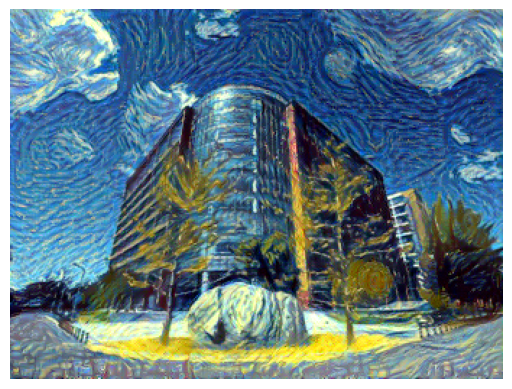

The Image has been Generated Successfully at ./output/testRohm_Starry_Night.jpg


In [30]:
# 初始化模型和特征
vgg = VGGFeatures()
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 初始化目标图像
target_image = content_image.clone().requires_grad_(True)

# 优化器
optimizer = optim.Adam([target_image], lr=0.003)

# 训练循环
num_steps = 3000
content_weight = 1e3
style_weight = 1e10
init_loss = 0

for step in range(num_steps):
    target_features = get_features(target_image, vgg)
    c_loss = content_loss(content_weight, content_features['conv9'], target_features['conv9'])
    s_loss = style_loss(style_weight, style_grams, target_features)
    total_loss = c_loss + s_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step == 0:
        init_loss = total_loss
    if step % 100 == 0:
        print(f"Step {step}, Content Loss:{c_loss.item()}, Style Loss:{s_loss.item()}")
        print(f"Total loss:{total_loss}, percentage:{(100*total_loss/init_loss)}%")

# 显示结果
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(output_path,bbox_inches='tight', pad_inches=0)
    plt.show()

imshow(target_image, title='Styled Image')


print(f"The Image has been Generated Successfully at {output_dir}/{content_name}_{style_name}.jpg")